In [ ]:
import numpy as np
import os
import pickle
import cloudpickle
from astropy.io import fits
from llamas_pyjamas.config import CALIB_DIR, OUTPUT_DIR, LUT_DIR
from llamas_pyjamas.constants import idx_lookup
from llamas_pyjamas.Flat.flatProcessing import produce_flat_extractions, reduce_flat
from llamas_pyjamas.Utils.utils import concat_extractions
from llamas_pyjamas.Arc.arcLlamas import arcTransfer
import llamas_pyjamas.Extract.extractLlamas as extract
from llamas_pyjamas.constants import RED_IDXS, GREEN_IDXS, BLUE_IDXS
import llamas_pyjamas.Arc.arcLlamasMulti as arc
import llamas_pyjamas.GUI.guiExtract as ge

2026-01-21 16:58:27,429	INFO worker.py:1888 -- Started a local Ray instance.


Fibre map path: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas/LUT/LLAMAS_FiberMap_rev04.dat


(raylet) [2026-01-21 16:58:37,358 E 30971 599205] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-58-26_757447_30960 is over 95% full, available space: 41.4245 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(raylet) [2026-01-21 16:58:47,448 E 30971 599205] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-58-26_757447_30960 is over 95% full, available space: 41.4237 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(raylet) [2026-01-21 16:58:57,544 E 30971 599205] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-58-26_757447_30960 is over 95% full, available space: 36.4159 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(raylet) [2026-01-21 16:59:07,560 E 30971 599205] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-58-26_757447_30960 is over 95% full, available space: 35.8178 GB; capacity: 926.352 GB. Object creation will fa

# Generating new wavelength solutions

### 1. selecting the arc file to extract 

In [ ]:
OUTPUT_DIR = '/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/wavelength_soln_comissioning/'

arc_filename   = '/Users/slh/Library/CloudStorage/Box-Box/slhughes/Llamas_Commissioning_Data/ut20241202-03/LLAMAS_2024-12-03T17_11_57.326_mef.fits'
ge.GUI_extract(arc_filename, output_dir=OUTPUT_DIR)

arc_picklename = os.path.join(OUTPUT_DIR, os.path.basename(arc_filename).replace('_mef.fits', '_extract.pkl'))
with open(arc_picklename, 'rb') as fp:
    batch_data = pickle.load(fp)
arcdict = extract.ExtractLlamas.loadExtraction(arc_picklename)
arcspec, metadata = arcdict['extractions'], arcdict['metadata']

file is /Users/slh/Library/CloudStorage/Box-Box/slhughes/Llamas_Commissioning_Data/ut20241202-03/LLAMAS_2024-12-03T17_11_57.326_mef.fits


2026-01-21 16:30:29,845	INFO worker.py:1888 -- Started a local Ray instance.
2026-01-21 16:30:30,083	INFO packaging.py:576 -- Creating a file package for local module '/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas'.
2026-01-21 16:30:30,256	INFO packaging.py:368 -- Pushing file package 'gcs://_ray_pkg_4a4ef283285c9ef5.zip' (31.97MiB) to Ray cluster...
2026-01-21 16:30:30,299	INFO packaging.py:381 -- Successfully pushed file package 'gcs://_ray_pkg_4a4ef283285c9ef5.zip'.


Trimmed HDU 1 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 2 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 3 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 4 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 5 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 6 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 7 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 8 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 9 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 10 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 11 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 12 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 1

(pid=29786) Calling ray.init() again after it has already been called.


(process_trace pid=29785) Trimmed HDU 1 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
(process_trace pid=29785) Bias index: 2 for 1/A/green


(process_trace pid=29786) 2026-01-21 16:30:38,912 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=1, side=A
(process_trace pid=29786) 2026-01-21 16:30:38,913 - llamas_pyjamas.Extract.extractLlamas - INFO - []
(process_trace pid=29786) 2026-01-21 16:30:38,913 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 0 of 298 for bench 1A channel blue
(process_trace pid=29786) 2026-01-21 16:30:38,988 - llamas_pyjamas.Extract.extractLlamas - INFO - []
(process_trace pid=29786) 2026-01-21 16:30:38,988 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 1 of 298 for bench 1A channel blue
(process_trace pid=29786) 2026-01-21 16:30:39,040 - llamas_pyjamas.Extract.extractLlamas - INFO - []
(process_trace pid=29786) 2026-01-21 16:30:39,040 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 2 of 298 for bench 1A channel blue
(process_trace pid=29788) 2026-01-21 16:30:39,002 - llamas_pyjamas.Extract.extractLlamas 

(process_trace pid=29786) Optimal True
(process_trace pid=29786) bench 1 self.side A channel blue
(process_trace pid=29785) bench 1 self.side A channel green
(process_trace pid=29788) bench 1 self.side B channel blue
(process_trace pid=29790) bench 2 self.side A channel red
(process_trace pid=29790) Dead fibers: [270, 299]
(process_trace pid=29784) bench 1 self.side B channel green


(process_trace pid=29790) 2026-01-21 16:30:39,095 - llamas_pyjamas.Extract.extractLlamas - INFO - [270, 299]
(process_trace pid=29790) 2026-01-21 16:30:39,095 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 1 of 298 for bench 2A channel red
(process_trace pid=29790) 2026-01-21 16:30:39,144 - llamas_pyjamas.Extract.extractLlamas - INFO - [270, 299]
(process_trace pid=29790) 2026-01-21 16:30:39,144 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 2 of 298 for bench 2A channel red


(process_trace pid=29787) bench 1 self.side B channel red


(raylet) [2026-01-21 16:30:39,848 E 29768 559251] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-30-29_271060_29734 is over 95% full, available space: 45.3807 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(pid=29789) Calling ray.init() again after it has already been called. [repeated 7x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(process_trace pid=29783) 2026-01-21 16:30:39,081 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=1, side=A [repeated 2x across cluster]
(process_trace pid=29786) 2026-01-21 16:30:44,024 - llamas_pyjamas.Extract.extractLlamas - INFO - [] [repeated 534x across cluster]
(process_trace pid=29786) 2026-01-21 16:30:44,024 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 

(pid=29789) Fibre map path: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas/LUT/LLAMAS_FiberMap_rev04.dat [repeated 7x across cluster]
(process_trace pid=29786) Bias file: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas/Bias/combined_bias.fits [repeated 8x across cluster]
(process_trace pid=29789) Trimmed HDU 24 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048] [repeated 191x across cluster]
(process_trace pid=29789) Bias index: 8 for 2/A/green [repeated 7x across cluster]
(process_trace pid=29789) Optimal True [repeated 7x across cluster]
(process_trace pid=29789) bench 2 self.side A channel green
(process_trace pid=29783) bench 1 self.side A channel red
(process_trace pid=29789) Dead fibers: [270, 299]
(process_trace pid=29789) Bias file: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas/Bias/combined_bias.fits [repeated 7x across cluster]
(process_trace pid=29785) Trimmed 

(raylet) [2026-01-21 16:30:59,987 E 29768 559251] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-30-29_271060_29734 is over 95% full, available space: 42.1797 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(process_trace pid=29789) 2026-01-21 16:30:53,248 - llamas_pyjamas.Extract.extractLlamas - INFO - Skipping dead fiber # 270
(process_trace pid=29785) 2026-01-21 16:30:54,634 - llamas_pyjamas.Extract.extractLlamas - INFO - [] [repeated 53x across cluster]
(process_trace pid=29788) 2026-01-21 16:30:54,447 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 299 of 300 for bench 1B channel blue [repeated 12x across cluster]
(process_trace pid=29789) 2026-01-21 16:30:54,642 - llamas_pyjamas.Extract.extractLlamas - INFO - [270, 299] [repeated 13x across cluster]
(process_trace pid=29787) 2026-01-21 16:30:54,594 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 299 of 300 for bench 1B channel red [repeated 18

(process_trace pid=29785) Bias index: 16 for 3/B/red


(process_trace pid=29784) 2026-01-21 16:31:00,702 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=3, side=A
(process_trace pid=29785) 2026-01-21 16:31:00,842 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=3, side=B


(process_trace pid=29784) Optimal True
(process_trace pid=29784) bench 3 self.side A channel green
(process_trace pid=29785) bench 3 self.side B channel red
(process_trace pid=29786) bench 2 self.side A channel blue
(process_trace pid=29786) Dead fibers: [270, 299]
(process_trace pid=29788) bench 2 self.side B channel blue
(process_trace pid=29790) bench 2 self.side B channel green
(process_trace pid=29787) bench 3 self.side A channel red


(process_trace pid=29788) 2026-01-21 16:31:03,308 - llamas_pyjamas.Extract.extractLlamas - INFO - Skipping dead fiber # 49
(process_trace pid=29787) 2026-01-21 16:31:05,008 - llamas_pyjamas.Extract.extractLlamas - INFO - [] [repeated 331x across cluster]
(process_trace pid=29786) 2026-01-21 16:31:05,071 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 83 of 298 for bench 2A channel blue [repeated 251x across cluster]
(process_trace pid=29786) 2026-01-21 16:31:05,071 - llamas_pyjamas.Extract.extractLlamas - INFO - [270, 299] [repeated 335x across cluster]
(process_trace pid=29787) 2026-01-21 16:31:05,008 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 81 of 298 for bench 3A channel red [repeated 248x across cluster]
(process_trace pid=29784) 2026-01-21 16:31:05,004 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 83 of 298 for bench 3A channel green [repeated 167x across cluster]
(process_trace pid=29789) 2026-01-21 16:31:00,746 - l

(process_trace pid=29783) Bias file: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas/Bias/combined_bias.fits
(process_trace pid=29789) Trimmed HDU 24 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048] [repeated 23x across cluster]
(process_trace pid=29789) Bias index: 15 for 3/A/blue [repeated 7x across cluster]
(process_trace pid=29789) Optimal True [repeated 7x across cluster]
(process_trace pid=29783) bench 2 self.side B channel red
(process_trace pid=29789) bench 3 self.side A channel blue
(process_trace pid=29783) Dead fibers: [49] [repeated 3x across cluster]
(process_trace pid=29784) Bias file: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas/Bias/combined_bias.fits


(raylet) [2026-01-21 16:31:20,094 E 29768 559251] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-30-29_271060_29734 is over 95% full, available space: 41.3011 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(process_trace pid=29786) 2026-01-21 16:31:20,589 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=4, side=B
(process_trace pid=29785) 2026-01-21 16:31:16,505 - llamas_pyjamas.Extract.extractLlamas - INFO - [] [repeated 101x across cluster]
(process_trace pid=29789) 2026-01-21 16:31:16,209 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 297 of 298 for bench 3A channel blue [repeated 67x across cluster]
(process_trace pid=29790) 2026-01-21 16:31:16,175 - llamas_pyjamas.Extract.extractLlamas - INFO - [49] [repeated 88x across cluster]
(process_trace pid=29785) 2026-01-21 16:31:16,505 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 299 of 300 for bench 3B c

(process_trace pid=29786) bench 4 self.side B channel red
(process_trace pid=29790) bench 4 self.side A channel blue
(process_trace pid=29785) bench 4 self.side B channel blue
(process_trace pid=29788) bench 4 self.side A channel green
(process_trace pid=29787) bench 4 self.side B channel green
(process_trace pid=29784) bench 4 self.side A channel red


(process_trace pid=29786)  RuntimeWarning: invalid value encountered in scalar divide (extractLlamas.py:175)
(process_trace pid=29787) 2026-01-21 16:31:16,495 - llamas_pyjamas.Extract.extractLlamas - INFO - Benchside 3A counts shape (298, 2048) [repeated 7x across cluster]
(process_trace pid=29783) 2026-01-21 16:31:16,181 - llamas_pyjamas.Extract.extractLlamas - INFO - Processing dead fibers: [49] [repeated 3x across cluster]
(process_trace pid=29783) 2026-01-21 16:31:16,181 - llamas_pyjamas.Extract.extractLlamas - INFO - Inserting dead fiber at index 49 [repeated 3x across cluster]
(process_trace pid=29783) 2026-01-21 16:31:16,182 - llamas_pyjamas.Extract.extractLlamas - INFO - New counts shape after dead fiber insertion: (298, 2048) [repeated 3x across cluster]
(process_trace pid=29789) 2026-01-21 16:31:20,689 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=3, side=B [repeated 4x across cluster]
(process_trace pid=29786) 2026-01-21 16:31:25

(process_fiber_shift pid=29789)  OptimizeWarning: Covariance of the parameters could not be estimated (fitting.py:720)
(raylet) [2026-01-21 16:31:50,204 E 29768 559251] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-30-29_271060_29734 is over 95% full, available space: 39.5306 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(process_fiber_shift pid=29788)  OptimizeWarning: Covariance of the parameters could not be estimated (fitting.py:720) [repeated 15x across cluster]
(process_fiber_shift pid=29786)  OptimizeWarning: Covariance of the parameters could not be estimated (fitting.py:720) [repeated 10x across cluster]
(raylet) [2026-01-21 16:32:00,233 E 29768 559251] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-30-29_271060_29734 is over 95% full, available space: 39.5303 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(process_fiber_shift pid=29785)  OptimizeWarning: Covariance of the p

In [3]:
arc.shiftArcX(arc_picklename)
shift_picklename = arc_picklename.replace('_extract.pkl', '_extract_shifted.pkl')


🔄 Ray already initialized - using existing Ray cluster
🔥 Using Ray multiprocessing for arc shift calculation...
Processing 7167 fiber shift calculations in parallel...
Completed 100/7167 fiber shift calculations
Completed 200/7167 fiber shift calculations
Completed 300/7167 fiber shift calculations
Completed 400/7167 fiber shift calculations
Completed 500/7167 fiber shift calculations
Completed 600/7167 fiber shift calculations
Completed 700/7167 fiber shift calculations
Completed 800/7167 fiber shift calculations
Completed 900/7167 fiber shift calculations
Completed 1000/7167 fiber shift calculations
Completed 1100/7167 fiber shift calculations
Completed 1200/7167 fiber shift calculations
Completed 1300/7167 fiber shift calculations
Completed 1400/7167 fiber shift calculations
Completed 1500/7167 fiber shift calculations
Completed 1600/7167 fiber shift calculations
Completed 1700/7167 fiber shift calculations
Completed 1800/7167 fiber shift calculations
Completed 1900/7167 fiber shift

2026-01-21 16:46:16,483 - llamas_pyjamas.Extract.extractLlamas - INFO - Saving batch extraction to: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/wavelength_soln_comissioning/LLAMAS_2024-12-03T17_11_57.326_extract_shifted.pkl


Completed 7167/7167 fiber shift calculations
Saved shifted arc extraction to /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/wavelength_soln_comissioning/LLAMAS_2024-12-03T17_11_57.326_extract_shifted.pkl


### Extract the appropriate flat field files

In [4]:
red_flat_file = '/Users/slh/Library/CloudStorage/Box-Box/slhughes/Llamas_Commissioning_Data/ut20241202-03/LLAMAS_2024-12-02T23_53_52.524_mef.fits'
green_flat_file = '/Users/slh/Library/CloudStorage/Box-Box/slhughes/Llamas_Commissioning_Data/ut20241202-03/LLAMAS_2024-12-02T23_48_34.754_mef.fits'
blue_flat_file = '/Users/slh/Library/CloudStorage/Box-Box/slhughes/Llamas_Commissioning_Data/ut20241202-03/LLAMAS_2024-12-02T23_48_34.754_mef.fits'

In [5]:
reduce_flat(red_flat_file, RED_IDXS, tracedir=CALIB_DIR, channel='red', save_dir=OUTPUT_DIR)
reduce_flat(green_flat_file, GREEN_IDXS, tracedir=CALIB_DIR, channel='green', save_dir=OUTPUT_DIR)
reduce_flat(blue_flat_file, BLUE_IDXS, tracedir=CALIB_DIR, channel='blue', save_dir=OUTPUT_DIR)

2026-01-21 16:46:35,399	INFO worker.py:1888 -- Started a local Ray instance.
2026-01-21 16:46:35,759	INFO packaging.py:576 -- Creating a file package for local module '/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas'.
2026-01-21 16:46:35,995	INFO packaging.py:368 -- Pushing file package 'gcs://_ray_pkg_5e725c9d188827c1.zip' (92.04MiB) to Ray cluster...
2026-01-21 16:46:36,123	INFO packaging.py:381 -- Successfully pushed file package 'gcs://_ray_pkg_5e725c9d188827c1.zip'.


Trimmed HDU 1 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 2 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 3 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 4 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 5 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 6 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 7 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 8 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 9 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 10 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 11 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 12 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 1

(pid=30297) Calling ray.init() again after it has already been called.


(pid=30303) Fibre map path: /tmp/ray/session_2026-01-21_16-46-34_558707_29734/runtime_resources/py_modules_files/_ray_pkg_5e725c9d188827c1/llamas_pyjamas/LUT/LLAMAS_FiberMap_rev04.dat
(process_trace pid=30298) Bias file: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas/Bias/combined_bias.fits
(process_trace pid=30303) Trimmed HDU 1 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]


(raylet) [2026-01-21 16:46:45,328 E 30285 579532] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-46-34_558707_29734 is over 95% full, available space: 40.0652 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.


(pid=30299) Fibre map path: /tmp/ray/session_2026-01-21_16-46-34_558707_29734/runtime_resources/py_modules_files/_ray_pkg_5e725c9d188827c1/llamas_pyjamas/LUT/LLAMAS_FiberMap_rev04.dat [repeated 7x across cluster]
(process_trace pid=30303) Bias file: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas/Bias/combined_bias.fits [repeated 7x across cluster]
(process_trace pid=30303) Trimmed HDU 20 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048] [repeated 152x across cluster]
(process_trace pid=30303) Bias index: 13 for 3/A/red
(process_trace pid=30301) Optimal True
(process_trace pid=30301) bench 4 self.side B channel red
(process_trace pid=30298) Dead fibers: [49]


(process_trace pid=30301) 2026-01-21 16:46:47,091 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=4, side=B
(process_trace pid=30301) 2026-01-21 16:46:47,099 - llamas_pyjamas.Extract.extractLlamas - INFO - []
(process_trace pid=30301) 2026-01-21 16:46:47,099 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 0 of 298 for bench 4B channel red
(pid=30299) Calling ray.init() again after it has already been called. [repeated 7x across cluster]
(process_trace pid=30301) 2026-01-21 16:46:47,164 - llamas_pyjamas.Extract.extractLlamas - INFO - []
(process_trace pid=30301) 2026-01-21 16:46:47,164 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 1 of 298 for bench 4B channel red
(process_trace pid=30301) 2026-01-21 16:46:47,213 - llamas_pyjamas.Extract.extractLlamas - INFO - []
(process_trace pid=30301) 2026-01-21 16:46:47,213 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 2 of 298 for bench 4B chan

(process_trace pid=30303) bench 3 self.side A channel red


(process_trace pid=30300) 2026-01-21 16:46:47,317 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=1, side=A
(process_trace pid=30300)  RuntimeWarning: invalid value encountered in scalar divide (extractLlamas.py:175)
(process_trace pid=30298) 2026-01-21 16:46:47,265 - llamas_pyjamas.Extract.extractLlamas - INFO - [49]
(process_trace pid=30298) 2026-01-21 16:46:47,318 - llamas_pyjamas.Extract.extractLlamas - INFO - [49]
(process_trace pid=30298) 2026-01-21 16:46:49,802 - llamas_pyjamas.Extract.extractLlamas - INFO - Skipping dead fiber # 49
(process_trace pid=30304) 2026-01-21 16:46:47,313 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=1, side=B [repeated 2x across cluster]
(process_trace pid=30297) 2026-01-21 16:46:52,141 - llamas_pyjamas.Extract.extractLlamas - INFO - [] [repeated 554x across cluster]
(process_trace pid=30297) 2026-01-21 16:46:52,141 - llamas_pyjamas.Extract.extractLlamas - INFO -

(process_trace pid=30299) Trimmed HDU 24 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048] [repeated 39x across cluster]
(process_trace pid=30299) Bias index: 7 for 2/A/red [repeated 7x across cluster]
(process_trace pid=30299) Optimal True [repeated 7x across cluster]
(process_trace pid=30297) bench 3 self.side B channel red [repeated 3x across cluster]
(process_trace pid=30299) Dead fibers: [270, 299]
(process_trace pid=30299) bench 2 self.side A channel red [repeated 3x across cluster]


(process_trace pid=30303) 2026-01-21 16:47:03,447 - llamas_pyjamas.Extract.extractLlamas - INFO - [] [repeated 114x across cluster]
(process_trace pid=30303) 2026-01-21 16:47:03,447 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 297 of 298 for bench 3A channel red [repeated 143x across cluster]
(process_trace pid=30299) 2026-01-21 16:47:03,304 - llamas_pyjamas.Extract.extractLlamas - INFO - [270, 299] [repeated 28x across cluster]
(process_trace pid=30304) 2026-01-21 16:47:03,514 - llamas_pyjamas.Extract.extractLlamas - INFO - Benchside 1B counts shape (300, 2048) [repeated 7x across cluster]
(process_trace pid=30299) 2026-01-21 16:47:03,366 - llamas_pyjamas.Extract.extractLlamas - INFO - Processing dead fibers: [270, 299]
(process_trace pid=30299) 2026-01-21 16:47:03,367 - llamas_pyjamas.Extract.extractLlamas - INFO - Inserting dead fiber at index 299 [repeated 2x across cluster]
(process_trace pid=30299) 2026-01-21 16:47:03,368 - llamas_pyjamas.Extract.extractLlam

8


2026-01-21 16:47:10,163	ERROR node.py:997 -- Unable to succeed in selecting a random port.
2026-01-21 16:47:10,993	INFO worker.py:1888 -- Started a local Ray instance.
2026-01-21 16:47:11,288	INFO packaging.py:576 -- Creating a file package for local module '/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas'.
2026-01-21 16:47:11,509	INFO packaging.py:368 -- Pushing file package 'gcs://_ray_pkg_46f21a492f5ddf18.zip' (92.04MiB) to Ray cluster...
2026-01-21 16:47:11,610	INFO packaging.py:381 -- Successfully pushed file package 'gcs://_ray_pkg_46f21a492f5ddf18.zip'.


Trimmed HDU 1 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 2 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 3 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 4 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 5 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 6 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 7 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 8 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 9 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 10 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 11 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 12 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 1

(pid=30424) Calling ray.init() again after it has already been called.


(process_trace pid=30424) Trimmed HDU 1 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]


(raylet) [2026-01-21 16:47:20,984 E 30402 582663] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-47-10_159563_29734 is over 95% full, available space: 40.9775 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.


(pid=30432) Fibre map path: /tmp/ray/session_2026-01-21_16-47-10_159563_29734/runtime_resources/py_modules_files/_ray_pkg_46f21a492f5ddf18/llamas_pyjamas/LUT/LLAMAS_FiberMap_rev04.dat [repeated 7x across cluster]
(process_trace pid=30431) Bias file: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas/Bias/combined_bias.fits [repeated 7x across cluster]
(process_trace pid=30424) Trimmed HDU 23 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048] [repeated 176x across cluster]
(process_trace pid=30424) Bias index: 2 for 1/A/green


(process_trace pid=30431) 2026-01-21 16:47:22,434 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=4, side=A
(process_trace pid=30431) 2026-01-21 16:47:22,434 - llamas_pyjamas.Extract.extractLlamas - INFO - []
(process_trace pid=30431) 2026-01-21 16:47:22,434 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 0 of 300 for bench 4A channel green
(process_trace pid=30431) 2026-01-21 16:47:22,492 - llamas_pyjamas.Extract.extractLlamas - INFO - []
(process_trace pid=30431) 2026-01-21 16:47:22,493 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 1 of 300 for bench 4A channel green
(pid=30432) Calling ray.init() again after it has already been called. [repeated 7x across cluster]
(process_trace pid=30425) 2026-01-21 16:47:22,446 - llamas_pyjamas.Extract.extractLlamas - INFO - [270, 299]
(process_trace pid=30425) 2026-01-21 16:47:22,502 - llamas_pyjamas.Extract.extractLlamas - INFO - [270, 299]
(process_trace pid=304

(process_trace pid=30431) Optimal True
(process_trace pid=30431) bench 4 self.side A channel green
(process_trace pid=30426) bench 2 self.side B channel green
(process_trace pid=30426) Dead fibers: [49]


(process_trace pid=30426)  RuntimeWarning: invalid value encountered in scalar divide (extractLlamas.py:175)
(process_trace pid=30426) 2026-01-21 16:47:25,189 - llamas_pyjamas.Extract.extractLlamas - INFO - Skipping dead fiber # 49
(process_trace pid=30424) 2026-01-21 16:47:22,614 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=1, side=A [repeated 2x across cluster]
(process_trace pid=30424) 2026-01-21 16:47:27,541 - llamas_pyjamas.Extract.extractLlamas - INFO - [] [repeated 483x across cluster]
(process_trace pid=30424) 2026-01-21 16:47:27,541 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 79 of 298 for bench 1A channel green [repeated 647x across cluster]
(process_trace pid=30426) 2026-01-21 16:47:27,441 - llamas_pyjamas.Extract.extractLlamas - INFO - [49] [repeated 162x across cluster]
(process_trace pid=30432) 2026-01-21 16:47:22,526 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for 

(process_trace pid=30432) Trimmed HDU 24 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048] [repeated 15x across cluster]
(process_trace pid=30432) Bias index: 23 for 4/B/green [repeated 7x across cluster]
(process_trace pid=30428) Optimal True [repeated 7x across cluster]
(process_trace pid=30424) bench 1 self.side A channel green [repeated 3x across cluster]
(process_trace pid=30428) bench 3 self.side B channel green [repeated 3x across cluster]
(process_trace pid=30425) Dead fibers: [270, 299]


(process_trace pid=30423) 2026-01-21 16:47:38,556 - llamas_pyjamas.Extract.extractLlamas - INFO - [] [repeated 108x across cluster]
(process_trace pid=30423) 2026-01-21 16:47:38,556 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 299 of 300 for bench 1B channel green [repeated 138x across cluster]
(process_trace pid=30426) 2026-01-21 16:47:38,368 - llamas_pyjamas.Extract.extractLlamas - INFO - [49] [repeated 30x across cluster]
(process_trace pid=30428) 2026-01-21 16:47:38,571 - llamas_pyjamas.Extract.extractLlamas - INFO - Benchside 3B counts shape (300, 2048) [repeated 7x across cluster]
(process_trace pid=30426) 2026-01-21 16:47:38,439 - llamas_pyjamas.Extract.extractLlamas - INFO - Processing dead fibers: [49]
(process_trace pid=30426) 2026-01-21 16:47:38,439 - llamas_pyjamas.Extract.extractLlamas - INFO - Inserting dead fiber at index 49
(process_trace pid=30426) 2026-01-21 16:47:38,440 - llamas_pyjamas.Extract.extractLlamas - INFO - New counts shape after dead 

8


2026-01-21 16:47:44,589	INFO worker.py:1888 -- Started a local Ray instance.
2026-01-21 16:47:44,863	INFO packaging.py:576 -- Creating a file package for local module '/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas'.
2026-01-21 16:47:45,080	INFO packaging.py:368 -- Pushing file package 'gcs://_ray_pkg_3b5e2bb57b0449e3.zip' (92.04MiB) to Ray cluster...
2026-01-21 16:47:45,207	INFO packaging.py:381 -- Successfully pushed file package 'gcs://_ray_pkg_3b5e2bb57b0449e3.zip'.


Trimmed HDU 1 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 2 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 3 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 4 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 5 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 6 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 7 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 8 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 9 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 10 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 11 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 12 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
Trimmed HDU 1

(pid=30470) Calling ray.init() again after it has already been called.


(pid=30470) Fibre map path: /tmp/ray/session_2026-01-21_16-47-43_826537_29734/runtime_resources/py_modules_files/_ray_pkg_3b5e2bb57b0449e3/llamas_pyjamas/LUT/LLAMAS_FiberMap_rev04.dat
(process_trace pid=30470) Bias file: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas/Bias/combined_bias.fits
(process_trace pid=30470) Trimmed HDU 1 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048]
(process_trace pid=30470) Bias index: 3 for 1/A/blue
(process_trace pid=30477) Optimal True
(process_trace pid=30477) bench 4 self.side B channel blue
(process_trace pid=30470) bench 1 self.side A channel blue
(process_trace pid=30472) Dead fibers: [270, 299]


(process_trace pid=30477) 2026-01-21 16:47:53,718 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=4, side=B
(process_trace pid=30477) 2026-01-21 16:47:53,719 - llamas_pyjamas.Extract.extractLlamas - INFO - []
(process_trace pid=30477) 2026-01-21 16:47:53,719 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 0 of 298 for bench 4B channel blue
(process_trace pid=30472) 2026-01-21 16:47:53,849 - llamas_pyjamas.Extract.extractLlamas - INFO - [270, 299]
(process_trace pid=30474) 2026-01-21 16:47:53,879 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=3, side=A
(pid=30477) Calling ray.init() again after it has already been called. [repeated 7x across cluster]
(process_trace pid=30472) 2026-01-21 16:47:53,922 - llamas_pyjamas.Extract.extractLlamas - INFO - [270, 299]
(process_trace pid=30472) 2026-01-21 16:47:53,974 - llamas_pyjamas.Extract.extractLlamas - INFO - [270, 299]
(process_trace p

(pid=30477) Fibre map path: /tmp/ray/session_2026-01-21_16-47-43_826537_29734/runtime_resources/py_modules_files/_ray_pkg_3b5e2bb57b0449e3/llamas_pyjamas/LUT/LLAMAS_FiberMap_rev04.dat [repeated 7x across cluster]


(raylet) [2026-01-21 16:47:54,500 E 30456 584960] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-47-43_826537_29734 is over 95% full, available space: 39.8201 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(process_trace pid=30473) 2026-01-21 16:47:56,504 - llamas_pyjamas.Extract.extractLlamas - INFO - Skipping dead fiber # 49
(process_trace pid=30471) 2026-01-21 16:47:53,922 - llamas_pyjamas.Extract.extractLlamas - INFO - No dead fibers entry found in LUT for bench=1, side=B [repeated 2x across cluster]
(process_trace pid=30470) 2026-01-21 16:47:58,814 - llamas_pyjamas.Extract.extractLlamas - INFO - [] [repeated 552x across cluster]
(process_trace pid=30470) 2026-01-21 16:47:58,814 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 93 of 298 for bench 1A channel blue [repeated 734x across cluster]
(process_trace pid=30473) 2026-01-21 16:47:58,836 - llamas_pyjamas.Extract.extractLlamas - INFO - [49] [repeated 184x acros

(process_trace pid=30477) Bias file: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas/Bias/combined_bias.fits [repeated 7x across cluster]
(process_trace pid=30477) Trimmed HDU 24 from (2048, 2048) to (2048, 2048) based on DATASEC=[1:2048, 1:2048] [repeated 191x across cluster]
(process_trace pid=30477) Bias index: 24 for 4/B/blue [repeated 7x across cluster]
(process_trace pid=30473) Optimal True [repeated 7x across cluster]
(process_trace pid=30473) bench 2 self.side B channel blue [repeated 3x across cluster]
(process_trace pid=30476) bench 4 self.side A channel blue [repeated 3x across cluster]
(process_trace pid=30473) Dead fibers: [49]


(process_trace pid=30471) 2026-01-21 16:48:09,470 - llamas_pyjamas.Extract.extractLlamas - INFO - Benchside 1B counts shape (300, 2048) [repeated 7x across cluster]
(process_trace pid=30471) 2026-01-21 16:48:09,424 - llamas_pyjamas.Extract.extractLlamas - INFO - [] [repeated 14x across cluster]
(process_trace pid=30471) 2026-01-21 16:48:09,424 - llamas_pyjamas.Extract.extractLlamas - INFO - Extracting fiber # 299 of 300 for bench 1B channel blue [repeated 16x across cluster]
(process_trace pid=30472) 2026-01-21 16:48:09,099 - llamas_pyjamas.Extract.extractLlamas - INFO - Processing dead fibers: [270, 299]
(process_trace pid=30472) 2026-01-21 16:48:09,100 - llamas_pyjamas.Extract.extractLlamas - INFO - Inserting dead fiber at index 299 [repeated 2x across cluster]
(process_trace pid=30472) 2026-01-21 16:48:09,100 - llamas_pyjamas.Extract.extractLlamas - INFO - New counts shape after dead fiber insertion: (300, 2048)
2026-01-21 16:48:12,474 - llamas_pyjamas.Extract.extractLlamas - INFO -

8


In [6]:
import sys
from llamas_pyjamas.Trace import traceLlamasMaster
sys.modules['tracellamasMaster'] = traceLlamasMaster


import pickle
combined_flat_file = os.path.join(OUTPUT_DIR, 'combined_flat_extractions.pkl')
_ex = [os.path.join(OUTPUT_DIR, 'red_extractions_flat.pkl'), os.path.join(OUTPUT_DIR, 'green_extractions_flat.pkl'), os.path.join(OUTPUT_DIR, 'blue_extractions_flat.pkl')]
concat_extractions(_ex, combined_flat_file)

red_extract = extract.ExtractLlamas.loadExtraction(os.path.join(OUTPUT_DIR, 'red_extractions_flat.pkl'))
green_extract = extract.ExtractLlamas.loadExtraction(os.path.join(OUTPUT_DIR, 'green_extractions_flat.pkl'))
blue_extract = extract.ExtractLlamas.loadExtraction(os.path.join(OUTPUT_DIR, 'blue_extractions_flat.pkl'))

print(combined_flat_file)
print(len(red_extract['extractions']))
print(len(green_extract['extractions']))
print(len(blue_extract['extractions']))

import llamas_pyjamas.Extract.extractLlamas as extract # type: ignore

flatdict = extract.ExtractLlamas.loadExtraction(combined_flat_file)
print(len(flatdict['extractions']))

# This sets a reference point to use for relative throughput calculations
flatdict['extractions'][10].relative_throughput[5] = 0.96
flatdict['extractions'][10].relative_throughput

/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/wavelength_soln_comissioning/combined_flat_extractions.pkl
8
8
8
24


array([0.  , 0.  , 0.  , 0.  , 0.  , 0.96, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [7]:
import cloudpickle
from llamas_pyjamas.constants import idx_lookup
import llamas_pyjamas.Extract.extractLlamas as extract

def reorder_extraction_to_standard(input_pickle, output_pickle=None):
    """
    Reorder an extraction pickle to match the standard LLAMAS extension ordering.
    
    Standard order is: red1A, green1A, blue1A, red1B, green1B, blue1B, ...
    
    Args:
        input_pickle: Path to the input extraction pickle
        output_pickle: Path for output (default: replaces input with '_reordered.pkl')
    
    Returns:
        Path to the reordered pickle file
    """
    # Load the extraction
    data = extract.ExtractLlamas.loadExtraction(input_pickle)
    extractions = data['extractions']
    metadata = data['metadata']
    
    # Build a mapping from (channel, bench, side) -> current index
    current_mapping = {}
    for i, meta in enumerate(metadata):
        key = (meta['channel'].lower(), str(meta['bench']), meta['side'].upper())
        current_mapping[key] = i
    
    # Print current ordering for debugging
    print("Current extension order:")
    for i, meta in enumerate(metadata):
        print(f"  {i}: {meta['channel']} {meta['bench']}{meta['side']} (nfibers={meta['nfibers']})")
    
    # Create new lists in standard order
    new_extractions = []
    new_metadata = []
    
    # Sort by idx_lookup value to get standard order
    sorted_keys = sorted(idx_lookup.keys(), key=lambda k: idx_lookup[k])
    
    print("\nReordering to standard order:")
    for new_idx, key in enumerate(sorted_keys):
        channel, bench, side = key
        lookup_key = (channel.lower(), str(bench), side.upper())
        
        if lookup_key in current_mapping:
            old_idx = current_mapping[lookup_key]
            new_extractions.append(extractions[old_idx])
            new_metadata.append(metadata[old_idx])
            print(f"  {new_idx}: {channel} {bench}{side} <- was index {old_idx}")
        else:
            print(f"  WARNING: {channel} {bench}{side} not found in input!")
    
    # Save the reordered extraction
    if output_pickle is None:
        output_pickle = input_pickle.replace('.pkl', '_reordered.pkl')
    
    # Create new dict structure (include primary_header if present)
    reordered_data = {
        'extractions': new_extractions,
        'metadata': new_metadata
    }
    if 'primary_header' in data:
        reordered_data['primary_header'] = data['primary_header']
    
    # Use cloudpickle like the rest of the codebase
    with open(output_pickle, 'wb') as f:
        cloudpickle.dump(reordered_data, f)
    
    print(f"\nSaved reordered extraction to: {output_pickle}")
    return output_pickle


In [8]:
# arc.fiberRelativeThroughput(combined_flat_file, shift_picklename)

reordered_flat = reorder_extraction_to_standard(combined_flat_file)
# Then use the reordered file:
arc.fiberRelativeThroughput(reordered_flat, shift_picklename)


Current extension order:
  0: red 1A (nfibers=298)
  1: red 1B (nfibers=300)
  2: red 2A (nfibers=298)
  3: red 2B (nfibers=297)
  4: red 3A (nfibers=298)
  5: red 3B (nfibers=300)
  6: red 4A (nfibers=300)
  7: red 4B (nfibers=298)
  8: green 1A (nfibers=298)
  9: green 1B (nfibers=300)
  10: green 2A (nfibers=298)
  11: green 2B (nfibers=297)
  12: green 3A (nfibers=298)
  13: green 3B (nfibers=300)
  14: green 4A (nfibers=300)
  15: green 4B (nfibers=298)
  16: blue 1A (nfibers=298)
  17: blue 1B (nfibers=300)
  18: blue 2A (nfibers=298)
  19: blue 2B (nfibers=297)
  20: blue 3A (nfibers=298)
  21: blue 3B (nfibers=300)
  22: blue 4A (nfibers=300)
  23: blue 4B (nfibers=298)

Reordering to standard order:
  0: red 1A <- was index 0
  1: green 1A <- was index 8
  2: blue 1A <- was index 16
  3: red 1B <- was index 1
  4: green 1B <- was index 9
  5: blue 1B <- was index 17
  6: red 2A <- was index 2
  7: green 2A <- was index 10
  8: blue 2A <- was index 18
  9: red 2B <- was index 3

2026-01-21 16:48:33,737	INFO worker.py:1888 -- Started a local Ray instance.


✅ Ray initialized successfully with 10 cores
🔥 Using Ray multiprocessing for fiber throughput calculation...
Processing 7167 fiber throughput calculations in parallel...
1A red Fiber #8:  Throughput = 1.020
1A red Fiber #25:  Throughput = 0.834
1A red Fiber #91:  Throughput = 0.830
1A red Fiber #143:  Throughput = 1.199
1A red Fiber #166:  Throughput = 1.116
1A red Fiber #282:  Throughput = 1.088
1A red Fiber #286:  Throughput = 1.118
1A green Fiber #40:  Throughput = 0.789
1A green Fiber #70:  Throughput = 0.947
1A green Fiber #171:  Throughput = 1.041
1A green Fiber #221:  Throughput = 1.065
1A blue Fiber #11:  Throughput = 0.983
1A blue Fiber #232:  Throughput = 0.893
1A blue Fiber #265:  Throughput = 0.688
1A blue Fiber #292:  Throughput = 0.802
1B red Fiber #236:  Throughput = 1.073
1B red Fiber #257:  Throughput = 0.840
1B red Fiber #274:  Throughput = 1.042
1B red Fiber #285:  Throughput = 1.088
1B green Fiber #8:  Throughput = 0.794
1B green Fiber #80:  Throughput = 0.681
1B gr

2026-01-21 16:48:39,781 - llamas_pyjamas.Extract.extractLlamas - INFO - Saving batch extraction to: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/wavelength_soln_comissioning/LLAMAS_2024-12-03T17_11_57.326_extract_shifted_shifted_tp.pkl
INFO:llamas_pyjamas.Extract.extractLlamas:Saving batch extraction to: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/wavelength_soln_comissioning/LLAMAS_2024-12-03T17_11_57.326_extract_shifted_shifted_tp.pkl


1A red Fiber #0:  Throughput = 1.102
1A red Fiber #55:  Throughput = 1.190
1A red Fiber #280:  Throughput = 0.747
1A green Fiber #65:  Throughput = 1.064
1A green Fiber #213:  Throughput = 0.956
1A green Fiber #230:  Throughput = 0.859
1A blue Fiber #73:  Throughput = 0.926
1A blue Fiber #171:  Throughput = 1.003
1A blue Fiber #187:  Throughput = 0.802
1A blue Fiber #197:  Throughput = 0.562
1A blue Fiber #199:  Throughput = 0.685
1B red Fiber #18:  Throughput = 0.956
1B green Fiber #42:  Throughput = 0.765
1B green Fiber #59:  Throughput = 0.848
1B green Fiber #93:  Throughput = 0.933
1B green Fiber #151:  Throughput = 0.920
1B blue Fiber #15:  Throughput = 0.699
1B blue Fiber #206:  Throughput = 0.476
1B blue Fiber #241:  Throughput = 0.643
1B blue Fiber #275:  Throughput = 0.649
2A red Fiber #0:  Throughput = 1.134
2A red Fiber #53:  Throughput = 1.102
2A red Fiber #130:  Throughput = 1.228
2A red Fiber #162:  Throughput = 1.322
2A green Fiber #40:  Throughput = 0.845
2A green Fiber

(raylet) [2026-01-21 16:48:43,758 E 30499 587348] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-48-32_343159_29734 is over 95% full, available space: 31.4179 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(raylet) [2026-01-21 16:48:53,842 E 30499 587348] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-48-32_343159_29734 is over 95% full, available space: 28.4167 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(raylet) [2026-01-21 16:49:03,940 E 30499 587348] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-48-32_343159_29734 is over 95% full, available space: 28.2861 GB; capacity: 926.352 GB. Object creation will fail if spilling is required.
(raylet) [2026-01-21 16:49:13,960 E 30499 587348] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2026-01-21_16-48-32_343159_29734 is over 95% full, available space: 28.2857 GB; capacity: 926.352 GB. Object creation will fa

In [9]:
import pickle

with open(combined_flat_file, 'rb') as f:
    flat_data = pickle.load(f)
    
with open(shift_picklename, 'rb') as f:
    arc_data = pickle.load(f)

# Find the 1B extension and compare
for ext, meta in enumerate(flat_data['metadata']):
    if meta.get('bench') == 1 and meta.get('side') == 'B':
        print(f"Extension {ext}: {meta.get('bench')}{meta.get('side')} {meta.get('channel')}")
        print(f"  Flat nfibers: {meta['nfibers']}")
        print(f"  Arc xshift shape: {arc_data['extractions'][ext].xshift.shape[0]}")



Extension 1: 1B red
  Flat nfibers: 300
  Arc xshift shape: 298
Extension 9: 1B green
  Flat nfibers: 300
  Arc xshift shape: 297
Extension 17: 1B blue
  Flat nfibers: 300
  Arc xshift shape: 300


🔄 Ray already initialized - using existing Ray cluster
🔥 Using Ray multiprocessing for arc wavelength solution...
Loading arc extraction
Fitting wavelength solution
Processing 4A red
Inital arcfit <PypeItFit:  items={'xval': True, 'yval': True, 'order': True, 'x2': False, 'weights': True, 'fitc': True, 'fitcov': False, 'gpm': True, 'success': True, 'func': True, 'minx': True, 'maxx': True, 'minx2': False, 'maxx2': False}>


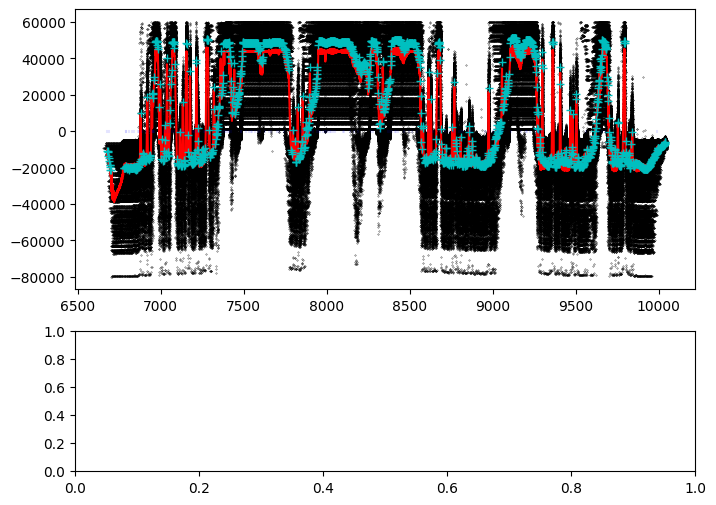

Found 123 lines in the ThAr linelist
Transferring arc solution to all fibers in LLAMAS red channels using Ray...
Processing 8 extensions for red channel in parallel...
Processing 4A green
Inital arcfit <PypeItFit:  items={'xval': True, 'yval': True, 'order': True, 'x2': False, 'weights': True, 'fitc': True, 'fitcov': False, 'gpm': True, 'success': True, 'func': True, 'minx': True, 'maxx': True, 'minx2': False, 'maxx2': False}>


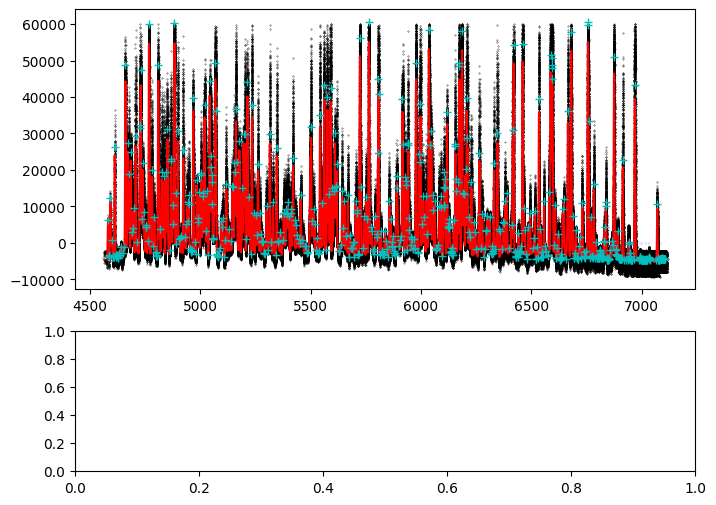

Found 32 lines in the ThAr linelist
Transferring arc solution to all fibers in LLAMAS green channels using Ray...
Processing 8 extensions for green channel in parallel...
Processing 4A blue
Inital arcfit <PypeItFit:  items={'xval': True, 'yval': True, 'order': True, 'x2': False, 'weights': True, 'fitc': True, 'fitcov': False, 'gpm': True, 'success': True, 'func': True, 'minx': True, 'maxx': True, 'minx2': False, 'maxx2': False}>


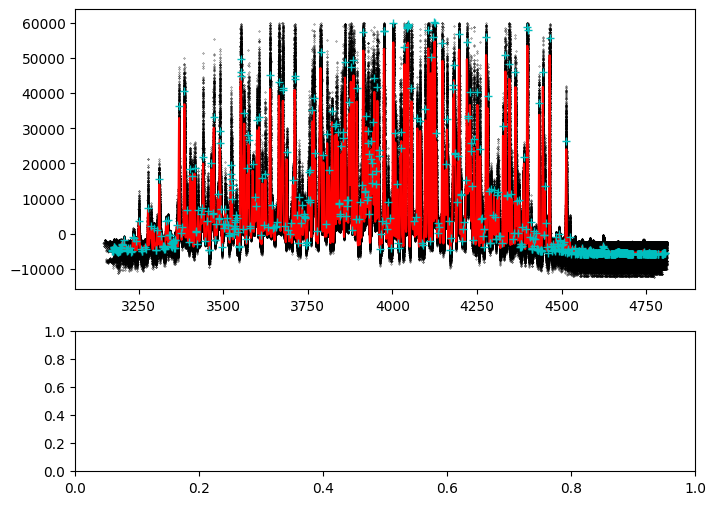

2026-01-21 16:58:54,141 - llamas_pyjamas.Extract.extractLlamas - INFO - Saving batch extraction to: /Users/slh/Documents/Projects/Magellan_dev/LLAMAS/llamas-pyjamas/llamas_pyjamas/output/test_wavelength_solution.pkl


Found 146 lines in the ThAr linelist
Transferring arc solution to all fibers in LLAMAS blue channels using Ray...
Processing 8 extensions for blue channel in parallel...
Saving wavelength solution to disk


()

In [2]:
# tp=shift_picklename.replace('.pkl','_shifted_tp.pkl')
tmp = '/Users/slh/Documents/Projects/Magellan_dev/LLAMAS/testing/wavelength_soln_comissioning/LLAMAS_2024-12-03T17_11_57.326_extract_shifted_shifted_tp.pkl'
# print(tp)
arc.arcSolve(tmp, savefile='test_wavelength_solution.pkl', savedir=OUTPUT_DIR)

### Checking the wavelength solution

In [3]:
from llamas_pyjamas.Utils.utils import check_reference_arc_wavelength_ranges
ref = os.path.join(OUTPUT_DIR, 'test_wavelength_solution.pkl')
check_reference_arc_wavelength_ranges(ref)

WAVELENGTH RANGES BY EXTENSION
Extension  0: 1A red    | 5761.10 - 10430.70 Å | 298 fibers
Extension  1: 1A green  | 4555.58 - 7104.81 Å | 298 fibers
Extension  2: 1A blue   | 3153.93 - 4818.32 Å | 298 fibers
Extension  3: 1B red    | 4671.13 - 10118.52 Å | 300 fibers
Extension  4: 1B green  | 4570.32 - 7110.59 Å | 300 fibers
Extension  5: 1B blue   | 3143.59 - 4820.10 Å | 300 fibers
Extension  6: 2A red    | 5071.87 - 10050.27 Å | 298 fibers
Extension  7: 2A green  | 4573.68 - 7114.87 Å | 298 fibers
Extension  8: 2A blue   | 3161.26 - 4811.17 Å | 298 fibers
Extension  9: 2B red    | 5077.43 - 10115.02 Å | 297 fibers
Extension 10: 2B green  | 4571.59 - 7114.87 Å | 297 fibers
Extension 11: 2B blue   | 3152.14 - 4819.64 Å | 297 fibers
Extension 12: 3A red    | 5089.65 - 11072.63 Å | 298 fibers
Extension 13: 3A green  | 4567.13 - 7113.00 Å | 298 fibers
Extension 14: 3A blue   | 3160.56 - 4818.70 Å | 298 fibers
Extension 15: 3B red    | 5136.09 - 10050.27 Å | 300 fibers
Extension 16: 3B gr

{'extensions': [{'index': 0,
   'bench': '1',
   'side': 'A',
   'channel': 'red',
   'nfibers': 298,
   'has_wavelength_data': True,
   'wave_min': np.float64(5761.103435716779),
   'wave_max': np.float64(10430.702332750368)},
  {'index': 1,
   'bench': '1',
   'side': 'A',
   'channel': 'green',
   'nfibers': 298,
   'has_wavelength_data': True,
   'wave_min': np.float64(4555.5780334481915),
   'wave_max': np.float64(7104.8057969794645)},
  {'index': 2,
   'bench': '1',
   'side': 'A',
   'channel': 'blue',
   'nfibers': 298,
   'has_wavelength_data': True,
   'wave_min': np.float64(3153.928333719152),
   'wave_max': np.float64(4818.319116267853)},
  {'index': 3,
   'bench': '1',
   'side': 'B',
   'channel': 'red',
   'nfibers': 300,
   'has_wavelength_data': True,
   'wave_min': np.float64(4671.1288205086985),
   'wave_max': np.float64(10118.522817492796)},
  {'index': 4,
   'bench': '1',
   'side': 'B',
   'channel': 'green',
   'nfibers': 300,
   'has_wavelength_data': True,
   '